# Real wave number

In [175]:
using Plots, SparseArrays, LinearAlgebra, IterativeSolvers, Revise
includet("nonuniformMultiGrid.jl")
includet("constructions2D.jl")
includet("grid_constructions1D.jl")
includet("grid_constructions2D.jl")
includet("linespacecs.jl")
includet("MG_preconditioner.jl")

In [270]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
σ = -10000* ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
sigmas = spdiagm(vec(σ))
H = helmholtz2D(grid,sigmas);

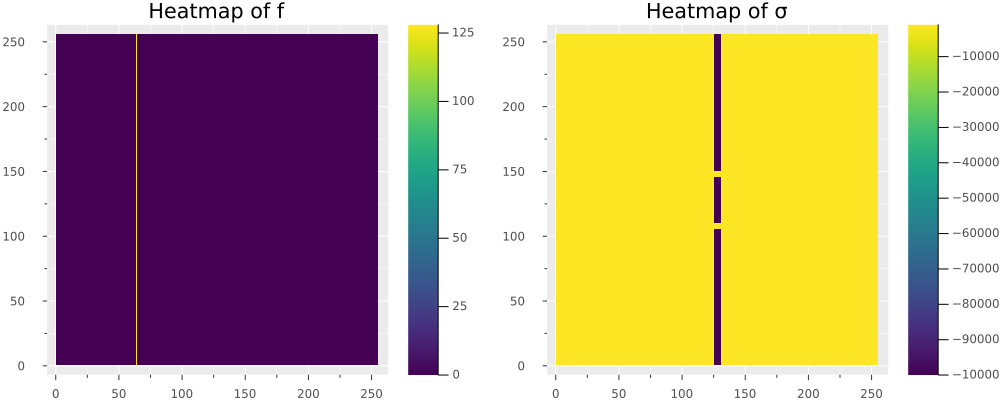

In [271]:
p1 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p2 = heatmap(reshape(σ,length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, layout = (1, 2), size = (1000, 400))

In [178]:
sol = H\f;

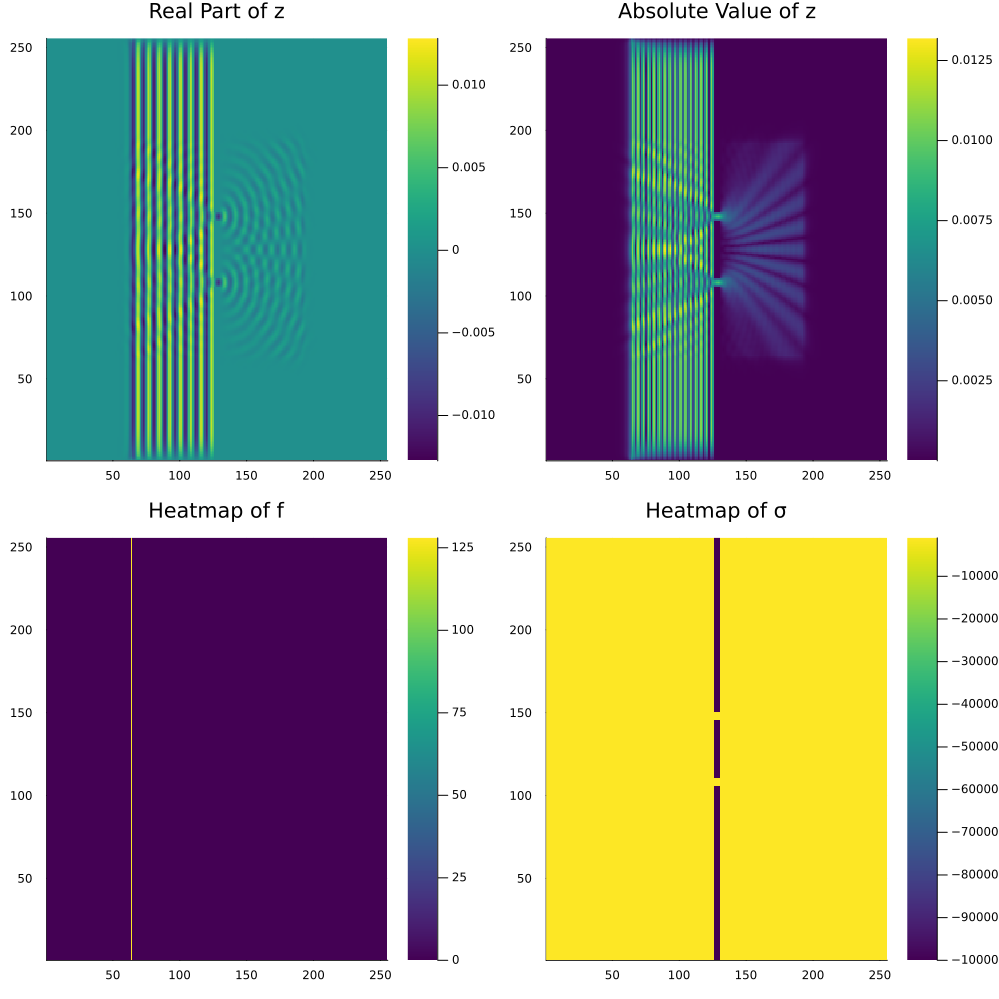

In [274]:
theme(:default)
z = reshape(sol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of z")
p2 = heatmap(abs.(z), color=:viridis, title="Absolute Value of z")
p3 = heatmap(reshape(f,length(grid),length(grid)), color=:viridis, title="Heatmap of f")
p4 = heatmap(reshape(σ,length(grid),length(grid)), color=:viridis, title="Heatmap of σ")

plot(p1, p2, p3, p4, layout = (2, 2), size = (1000, 1000))


In [268]:
u = zeros(length(f))
errors = Float64[]

for _ in 1:20
    u = nonUniformVcycle2D(
        grid=grid,
        A=H,
        f=f,
        u=u,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol - u)
    push!(errors, error)
end

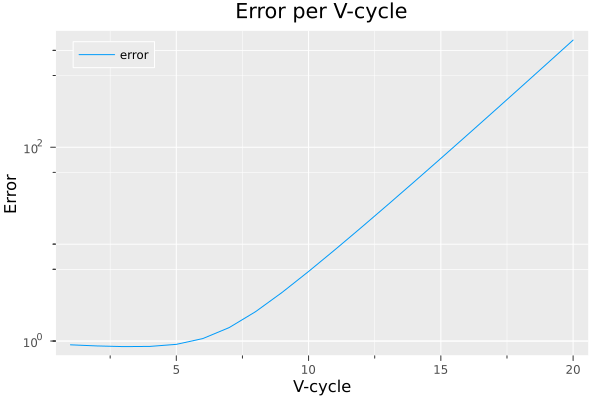

In [269]:
theme(:ggplot2)
plot(errors, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

Eigenvectors aren't easy to derive anymore, still need to find good explainer. Well we don't expect convergence without a wall and the wall acts like boundary conditions...

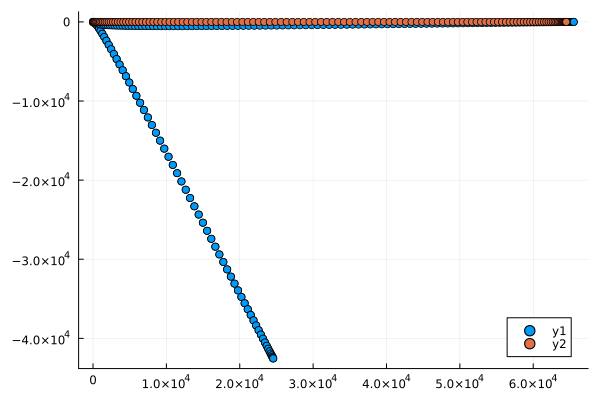

In [242]:
P = Poisson1D(grid)
Pr = Poisson1D(range(0,1,128))
eigenvalues = eigvals(Matrix(P))
scatter(real(eigenvalues),imag(eigenvalues))
eigenvalues = eigvals(Matrix(Pr))
scatter!(real(eigenvalues),imag(eigenvalues))

# Complex wave number

In [319]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+1*im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas_shifted = spdiagm(vec(σ_shifted))
H_shifted = helmholtz2D(grid,sigmas_shifted);

In [320]:
sol_shifted = H_shifted\f;

In [334]:
u_shifted = zeros(length(f))
errors_shifted = Float64[]
us = []

for i in 1:20
    u_shifted = nonUniformVcycle2D(
        grid=grid,
        A=H_shifted,
        f=f,
        u=u_shifted,
        nu1=1,
        nu2=1,
        recursion_depth=50)
    error = norm(sol_shifted - u_shifted)
    push!(errors_shifted, error)
    push!(us, u_shifted)
end

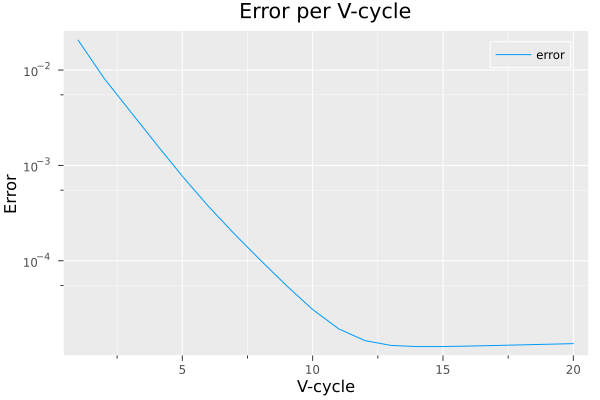

In [335]:
theme(:ggplot2)
plot(errors_shifted, title="Error per V-cycle", label="error", xlabel="V-cycle", ylabel="Error",yscale=:log10)

┌ Info: Saved animation to C:\Users\isido\AppData\Local\Temp\jl_9uJIvkRKx2.gif
└ @ Plots C:\Users\isido\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\isido\\AppData\\Local\\Temp\\jl_9uJIvkRKx2.gif")
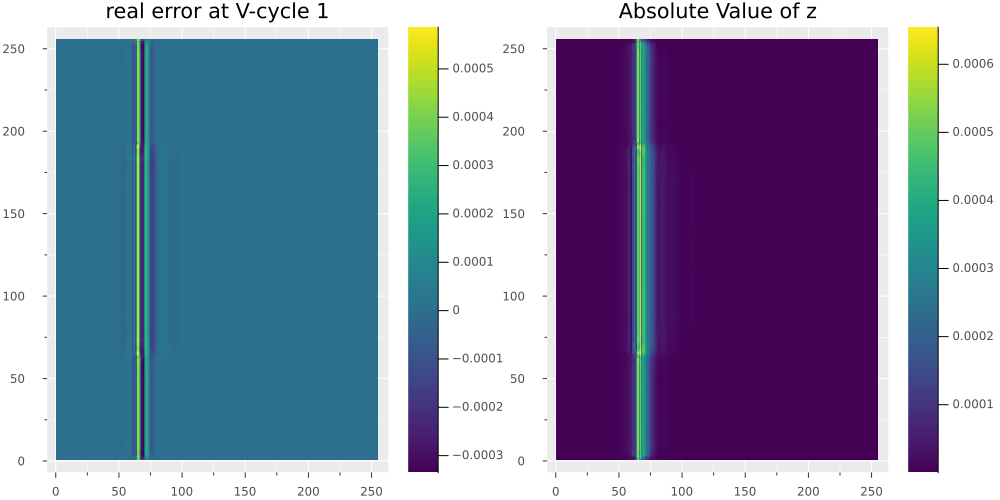

In [336]:
@gif for (i,uu) in enumerate(us) 
z = reshape(uu-sol_shifted, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="real error at V-cycle $i")
p2 = heatmap(abs.(z), color=:viridis, title="Absolute Value of z")
plot(p1, p2, layout = (1, 2), size = (1000, 500))
end fps = 1

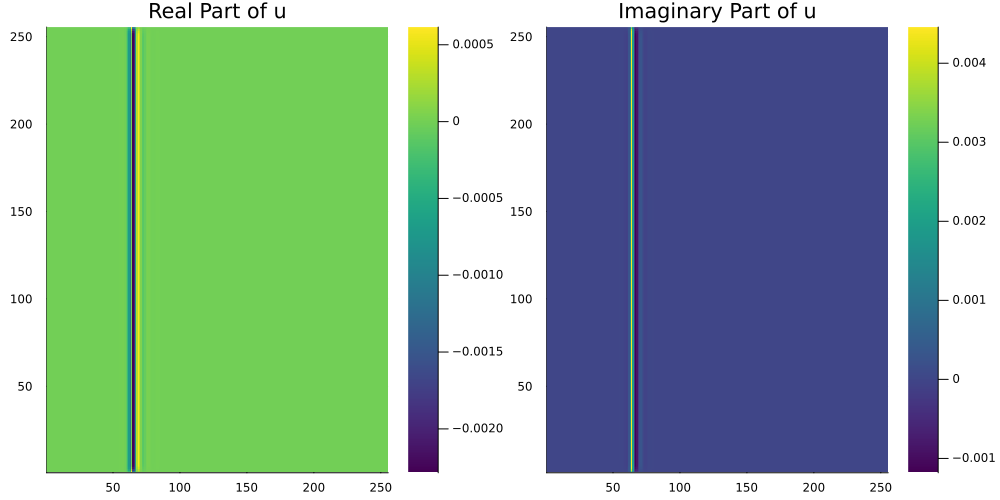

In [337]:
theme(:default)
z = reshape(u_shifted, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(imag(z), color=:viridis, title="Imaginary Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 500))


# GMRES

In [353]:
n = 2^7
grid,m = linspacecs(0,1,n+1,pi/6)
f =zeros(length(grid),length(grid))
f[:,64] .= n
f = vec(f);
complex_shift = (1+im)
σ = -10000 * ones(length(grid),length(grid))
σ[:, 126:130] .= -1000000
σ[union(106:110, 146:150), 126:130] .= -10000
σ_shifted = σ*complex_shift
sigmas = spdiagm(vec(σ))
sigmas_shifted = spdiagm(vec(σ_shifted))
H = helmholtz2D(grid,sigmas);
H_shifted = helmholtz2D(grid,sigmas_shifted);

pre = nonuniform_preconditioner(; grid=grid, H=H_shifted, f=f,nu1=3,nu2=3)

myPreconditioner(var"#pres#35"{Vector{ComplexF64}, SparseMatrixCSC{ComplexF64, Int64}, Vector{Float64}, Int64, Int64}(ComplexF64[-0.4921875 - 0.2841645856167689im, -0.484375 - 0.27965403663872496im, -0.4765625 - 0.275143487660681im, -0.46875 - 0.27063293868263705im, -0.4609375 - 0.26612238970459307im, -0.453125 - 0.26161184072654914im, -0.4453125 - 0.25710129174850516im, -0.4375 - 0.25259074277046123im, -0.4296875 - 0.2480801937924173im, -0.421875 - 0.24356964481437335im  …  1.421875 + 0.24356964481437335im, 1.4296875 + 0.2480801937924173im, 1.4375 + 0.25259074277046123im, 1.4453125 + 0.25710129174850516im, 1.453125 + 0.26161184072654914im, 1.4609375 + 0.26612238970459307im, 1.46875 + 0.27063293868263705im, 1.4765625 + 0.275143487660681im, 1.484375 + 0.27965403663872496im, 1.4921875 + 0.2841645856167689im], sparse([1, 2, 256, 1, 2, 3, 257, 2, 3, 4  …  65022, 65023, 65024, 64769, 65023, 65024, 65025, 64770, 65024, 65025], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6

In [354]:
presol, prehistory = gmres(H, f, Pl=pre, log=true,maxiter = 200 ,restart=500)

(ComplexF64[-1.1162010006613451e-7 + 2.9925664892020485e-7im, -2.1946417232849224e-7 + 5.975328397474863e-7im, -3.2103966450646304e-7 + 8.917726376001983e-7im, -4.142449981690704e-7 + 1.179127905656386e-6im, -4.960026020980888e-7 + 1.4583510161529382e-6im, -5.63977253060485e-7 + 1.7285581056537337e-6im, -6.173558733113952e-7 + 1.9866064621331283e-6im, -6.561124251460865e-7 + 2.2300713336075595e-6im, -6.794840186515251e-7 + 2.4577526271042975e-6im, -6.875144120935765e-7 + 2.669284610158601e-6im  …  -2.2548511595464192e-12 - 1.3924498832960893e-12im, -2.065972568043645e-12 - 1.299228405400159e-12im, -1.8663563898971978e-12 - 1.1932670323558837e-12im, -1.6566794379740107e-12 - 1.0752251927578577e-12im, -1.4379071594865583e-12 - 9.456098286913916e-13im, -1.2111082125272722e-12 - 8.056376806234157e-13im, -9.77533377397189e-13 - 6.562451622776336e-13im, -7.382566790217976e-13 - 4.993020356861019e-13im, -4.946612734000703e-13 - 3.3630349052971427e-13im, -2.4809079768687804e-13 - 1.69247722935

In [340]:
nsol, nhistory = gmres(H, f , log=true,maxiter = 600 ,restart=600)

(ComplexF64[-8.485415218515637e-9 - 2.929746271258761e-7im, 7.786893622939025e-8 - 2.696564784803577e-7im, 1.308371757444915e-7 - 6.969055209188817e-8im, 4.451276441367158e-8 + 1.8291675357960186e-7im, -3.5315195899495417e-8 + 2.619616548835091e-7im, 2.8334968107742417e-8 + 1.8800082623446737e-7im, 7.77864146307759e-8 - 1.0202189496683649e-7im, 7.313549104491768e-9 - 8.285472189326736e-8im, -1.535741518948354e-8 + 3.9148331424477496e-8im, 1.2191307504310497e-7 + 1.0389467392033261e-7im  …  1.7173433236233893e-27 + 7.1292989979963e-27im, 1.5487955538398007e-27 + 6.547471603450456e-27im, 1.3785336706803615e-27 + 5.927828115309232e-27im, 1.2071022902627629e-27 + 5.27266875426763e-27im, 1.0349519404927196e-27 + 4.584892627078542e-27im, 8.624328984797661e-28 + 3.867966022363625e-27im, 6.897949667505221e-28 + 3.1258752703136536e-27im, 5.171930887694217e-28 + 2.3630651270700777e-27im, 3.4469860645140455e-28 + 1.5843641400245434e-27im, 1.7231539029458416e-28 + 7.948989655759571e-28im], Not con

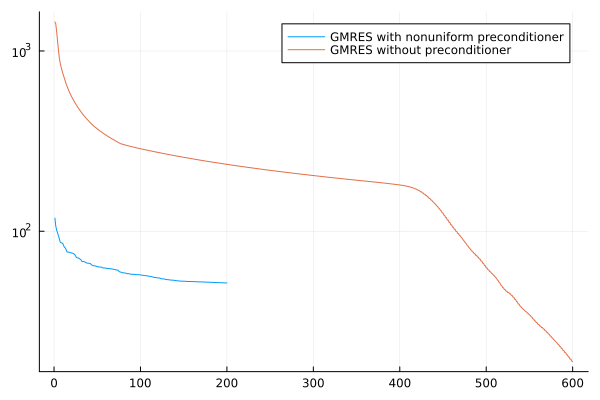

In [355]:
plot(prehistory.data[:resnorm], label="GMRES with nonuniform preconditioner", yscale=:log10)
plot!(nhistory.data[:resnorm], label="GMRES without preconditioner", yscale=:log10)

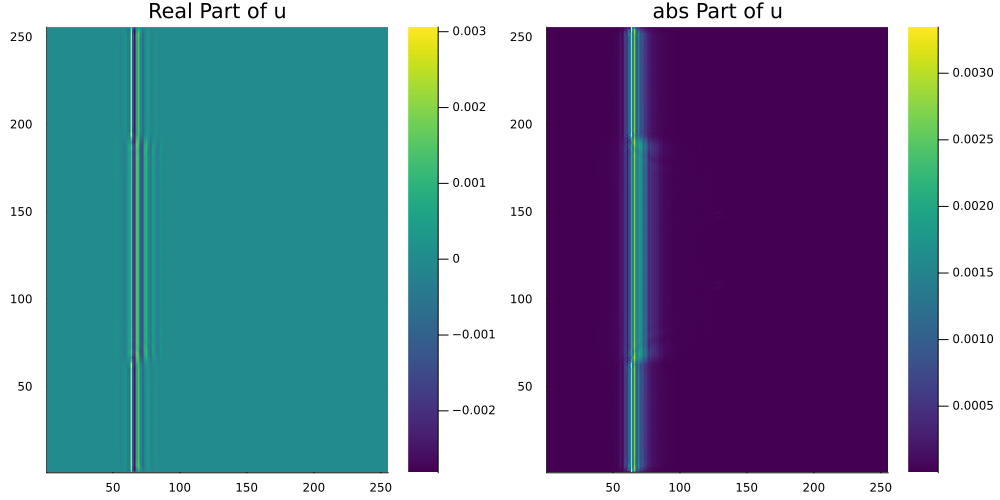

In [352]:
theme(:default)
z = reshape(presol, 2n-1, 2n-1)
p1 = heatmap(real(z), color=:viridis, title="Real Part of u")
p2 = heatmap(abs.(z), color=:viridis, title="abs Part of u")

plot(p1, p2, layout = (1, 2), size = (1000, 500))